In [3]:
import os
import warnings
import time
import json
import pickle  # used to save serialized files
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from datetime import datetime
import pandas as pd 
import numpy as np
from utils import read_json
from security_selection.model.sequence_model import LSTM

In [2]:
cd "/Users/Jenny/Documents/研究生/DeepDeep/WM-SecuritySelection"

/Users/Jenny/Documents/研究生/DeepDeep/WM-SecuritySelection


In [4]:
filepath = '/Users/Jenny/Documents/研究生/DeepLearning/drive-download-20211005T115705Z-001/MF_LargeCap_ExcessReturn_3Y.parquet'

# Codes for loading data

In [5]:
feat_window = 90

# performance measures window: number of years
pm_window = 3
lb_window = int(3 * pm_window * 365.25) + 1

# Window length between training samples: number of days
sample_window = 30

# test period start
test_start_date = '2020-06-30'

In [6]:
def prepare_data_for_er_ari(filepath, label_window=pm_window):
    er_ari_df = pd.read_parquet(filepath)
    

    data_dict = {ticker: er_ari_df[ticker].dropna() for ticker in er_ari_df.columns}
    tickers_to_remove = []
    
    label_dict = {}
    for ticker, series in tqdm(data_dict.items()):
        if series.isna().sum() == series.shape[0]:
            tickers_to_remove += [ticker]
            continue

        last_date = series.index[-1] - relativedelta(years=pm_window)
        if last_date <= series.index[0]:
            tickers_to_remove.append(ticker)
            continue

        index = series.loc[:series.index[-1] - relativedelta(years=pm_window)].index
        label_dict[ticker] = pd.Series([
            series[date + relativedelta(years=pm_window)] for date in index
        ], index=index)
        
    _ = [data_dict.pop(ticker) for ticker in tickers_to_remove]
    
    return data_dict, label_dict

In [7]:
data_dict, label_dict = prepare_data_for_er_ari(filepath)

100%|██████████| 1330/1330 [02:05<00:00, 10.58it/s]


In [8]:
tickers = list(data_dict.keys())

In [9]:
train_data = []
train_labels = []

test_data = []
test_labels = []

# test start date
checkpoint = datetime.strptime(test_start_date, '%Y-%m-%d') - relativedelta(years=pm_window)

for ticker in tqdm(tickers):    
    label = label_dict[ticker]
    if label.shape[0] == 0:
        continue
    ts = data_dict[ticker].loc[:label.index[-1]]

    indices = [np.arange(i, i+lb_window, feat_window) for i in range(0, ts.shape[0] - lb_window + 1, sample_window)]
    
    temp_data = np.array([ts.iloc[sub_indices].values for sub_indices in indices])
    if temp_data.shape[0] == 0:
        continue
    temp_labels = np.array([label.loc[ts.index[sub_indices[-1]]] for sub_indices in indices])
    
    train_indices = [idx for idx in range(temp_data.shape[0]) if ts.index[indices[idx][-1]] <= checkpoint]
    test_indices = [idx for idx in range(temp_data.shape[0]) if ts.index[indices[idx][-1]] > checkpoint]
    
    train_data += [temp_data[train_indices]] 
    train_labels += [temp_labels[train_indices]]
    
    test_data += [temp_data[test_indices]] 
    test_labels += [temp_labels[test_indices]]

100%|██████████| 1130/1130 [00:06<00:00, 178.57it/s]


In [10]:
train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, train_size=0.9)

# LSTM bayesian optimization

In [13]:
import hyperopt 
from hyperopt import fmin, tpe, hp
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [54]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

For this section we test the full hyperparameter set that consists of learning rate, batch size, and num epochs to have a general view of the optimality of Bayesian Optimization

In [19]:
learning_rate_total = []
batch_total = []
num_epochs_total = []
rmse_inverse_total = []
def objective_function_RMSE_total(learning_rate, batch_size, num_epochs):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_total.append(learning_rate)
    batch_total.append(int(batch_size))
    num_epochs_total.append(int(num_epochs))
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = int(num_epochs)
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_total.append(1/rmse_lstm)
    return 1/rmse_lstm

In [20]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_total,
    pbounds={'learning_rate': (0.0001, 0.05), 'batch_size':(30, 256), 'num_epochs':(20,80)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 71/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 72/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 74/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 75/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 76/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 77/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 78/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_los

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/69
382/382 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 70/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 74/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 75/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 76/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 77/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 78/78
163/163 [==============================] - 1s 8ms/step - loss: 0.0013 - val_los

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/72
171/171 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 70/72
171/171 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/72
171/171 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 72/72
171/171 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/72
516/516 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 70/72
516/516 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/72
516/516 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/72
516/516 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/79
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/79
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/79
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/79
233/233 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/79
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 74/79
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 75/79
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 76/79
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 77/79
233/233 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 78/79
233/233 [==============================] - 1s 6ms/step - loss: 0.0013 - val_los

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 72/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 74/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013


0.01189518880889612
200
39.94416644897892


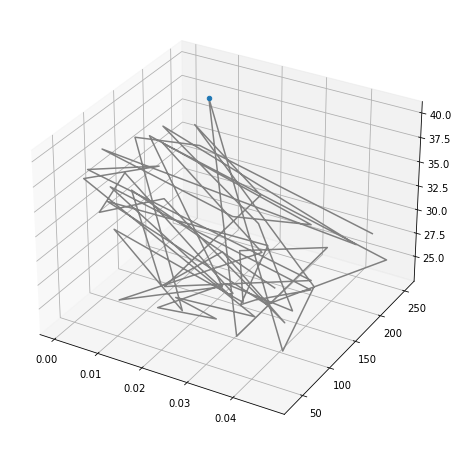

In [21]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_total
xline = learning_rate_total
yline = batch_total

maxlearning = max(rmse_inverse_total)
xmax = xline[rmse_inverse_total.index(maxlearning)]
ymax = yline[rmse_inverse_total.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

We test the full hyperparameter sets using more iterations.

In [15]:
learning_rate_total_moreiter = []
batch_total_moreiter = []
num_epochs_total_moreiter = []
rmse_inverse_total_moreiter = []
def objective_function_RMSE_total_moreiter(learning_rate, batch_size, num_epochs):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_total_moreiter.append(learning_rate)
    batch_total_moreiter.append(int(batch_size))
    num_epochs_total_moreiter.append(int(num_epochs))
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = int(num_epochs)
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_total_moreiter.append(1/rmse_lstm)
    return 1/rmse_lstm

In [16]:
optimizer_RMSE_moreiter =BayesianOptimization(f=objective_function_RMSE_total_moreiter,
    pbounds={'learning_rate': (0.0001, 0.05), 'batch_size':(30, 256), 'num_epochs':(20,80)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_moreiter.maximize(n_iter=100)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 74/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 75/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 76/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 77/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 78/78
273/273 [==============================] - 2s 6ms/step - loss: 0.0013 - val_los

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/71
374/374 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/71
374/374 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/71
374/374 [==============================] - 2s 5ms/step - loss: 0.0014 - val_loss: 0.0014


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/72
171/171 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/72
171/171 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/72
171/171 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/72
171/171 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/72
516/516 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 70/72
516/516 [==============================] - 2s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/72
516/516 [==============================] - 2s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/72
516/516 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/72
191/191 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/72
191/191 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/72
191/191 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/72
191/191 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/73
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 70/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 72/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 74/74
151/151 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 70/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 71/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 72/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 73/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 74/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 75/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 76/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 77/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 78/79
978/978 [==============================] - 4s 4ms/step - loss: 0.0014 - val_los

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 70/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 71/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 73/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 74/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 75/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 76/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 77/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 78/78
706/706 [==============================] - 3s 4ms/step - loss: 0.0014 - val_los

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/75
263/263 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/75
263/263 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/75
263/263 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/75
263/263 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/75
263/263 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 74/75
263/263 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 75/75
263/263 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/73
184/184 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/73
184/184 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 71/73
184/184 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 72/73
184/184 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/73
184/184 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 66/66
275/275 [==============================] - 2s 6ms/step - loss: 9.1550e-04 - val_loss: 8.1125e-04


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/72
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/72
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 71/72
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 72/72
179/179 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0012


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [37]:
learning_rate_total_moreiter

[0.03604419222276369,
 0.007423118951773941,
 0.01734348027944808,
 0.02101780626872441,
 0.04391806007590818,
 0.04722432122610496,
 0.03939046203926561,
 0.013125142924203352,
 0.00786394086967205,
 0.036457739491149534,
 0.021232286297120147,
 0.03323716365051818,
 0.042074815819240476,
 0.038200418893987786,
 0.03599566755249476,
 0.027440761030916586,
 0.0070550398892240546,
 0.03824098535090265,
 0.04750245785320143,
 0.005723832659744073,
 0.02791385559249386,
 0.01299200616618448,
 0.02735829220052857,
 0.006878830549799287,
 0.03117146047192227,
 0.01596617893930616,
 0.0033328621949482375,
 0.042683953377932085,
 0.005845052164258779,
 0.02098367288738901,
 0.0462087522124317,
 0.027614678127859654,
 0.020801661459848683,
 0.03166085759096344,
 0.021940604635017312,
 0.03709458611686028,
 0.002951728508465841,
 0.009754277999951261,
 0.005930226524881104,
 0.041348844116031826,
 0.017750791186175913,
 0.02346520320072184,
 0.006288962699726715,
 0.04267726166445986,
 0.042289

In [38]:
batch_total_moreiter


[124,
 98,
 72,
 151,
 76,
 152,
 150,
 164,
 81,
 194,
 136,
 245,
 140,
 102,
 223,
 183,
 61,
 91,
 242,
 165,
 168,
 33,
 100,
 134,
 235,
 211,
 81,
 223,
 165,
 219,
 98,
 104,
 39,
 55,
 61,
 79,
 53,
 128,
 39,
 147,
 74,
 202,
 218,
 141,
 87,
 200,
 33,
 213,
 164,
 90,
 48,
 45,
 111,
 178,
 254,
 132,
 39,
 43,
 54,
 227,
 46,
 171,
 158,
 245,
 88,
 33,
 49,
 104,
 251,
 121,
 71,
 79,
 64,
 144,
 215,
 133,
 118,
 60,
 101,
 69,
 216,
 190,
 145,
 164,
 217,
 36,
 209,
 182,
 118,
 35,
 118,
 137,
 208,
 64,
 139,
 231,
 92,
 174,
 179,
 214,
 120,
 44,
 121,
 219,
 96]

In [39]:
num_epochs_total_moreiter


[20,
 25,
 43,
 61,
 21,
 60,
 30,
 64,
 76,
 31,
 48,
 48,
 78,
 71,
 74,
 42,
 39,
 24,
 36,
 27,
 59,
 68,
 69,
 54,
 78,
 56,
 62,
 72,
 44,
 37,
 25,
 33,
 20,
 44,
 61,
 52,
 42,
 24,
 50,
 67,
 72,
 31,
 22,
 22,
 27,
 72,
 75,
 73,
 79,
 44,
 37,
 26,
 46,
 58,
 74,
 34,
 79,
 71,
 78,
 45,
 60,
 55,
 50,
 23,
 59,
 38,
 28,
 60,
 27,
 30,
 51,
 37,
 77,
 44,
 63,
 54,
 28,
 20,
 57,
 51,
 53,
 74,
 75,
 55,
 52,
 26,
 67,
 43,
 29,
 21,
 25,
 68,
 73,
 52,
 66,
 42,
 50,
 28,
 52,
 72,
 37,
 39,
 77,
 56,
 29]

In [40]:
rmse_inverse_total_moreiter

[28.558820007229205,
 36.701554278488686,
 28.748809703850746,
 38.37092675736193,
 28.989528479525017,
 28.840391933404565,
 25.33381998950424,
 28.968475185175578,
 44.48389224127497,
 28.94309575320318,
 36.16598801237171,
 28.971329403289726,
 28.30425188505233,
 27.81831394299377,
 28.974096393163393,
 28.95944714979833,
 38.534562816507446,
 27.013498409807358,
 28.819925060421184,
 36.792787167457995,
 28.639005039302553,
 28.828272588797493,
 26.88172550694597,
 40.67043638485846,
 28.160571900197873,
 28.864123772355505,
 41.668509164279484,
 28.554340417860512,
 37.98575118554663,
 28.743912890689682,
 28.555357287163105,
 28.650531472437088,
 28.140939993816428,
 28.97386336560757,
 28.978202059881394,
 28.985653795146774,
 38.10723164483321,
 28.77602836570878,
 39.76367089584262,
 28.088854745679413,
 28.364395501678068,
 28.632016368577343,
 35.879277746770235,
 28.118827953599407,
 28.29497155225362,
 28.55371160913696,
 28.984411677653842,
 28.700504204100067,
 38.21491

0.00786394086967205
81
44.48389224127497


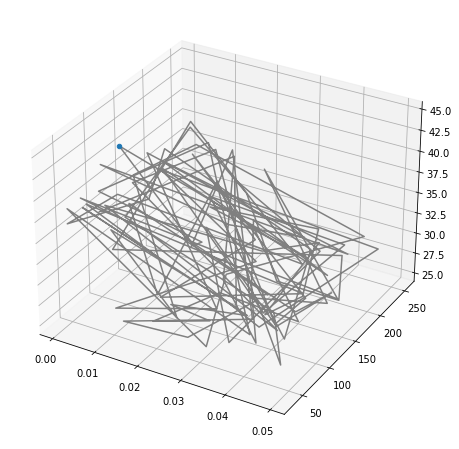

In [77]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_total_moreiter
xline = learning_rate_total_moreiter
yline = batch_total_moreiter

maxlearning = max(rmse_inverse_total_moreiter)
xmax = xline[rmse_inverse_total_moreiter.index(maxlearning)]
ymax = yline[rmse_inverse_total_moreiter.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

Zoomed-in run for the full parameter set to test the global optimality

In [78]:
rmse_inverse_total_moreiter_max = max(rmse_inverse_total_moreiter)
learning_rate_total_moreiter_max = learning_rate_total_moreiter[rmse_inverse_total_moreiter.index(rmse_inverse_total_moreiter_max)]
num_epochs_total_moreiter_max = num_epochs_total_moreiter[rmse_inverse_total_moreiter.index(rmse_inverse_total_moreiter_max)]
batch_total_moreiter_max = batch_total_moreiter[rmse_inverse_total_moreiter.index(rmse_inverse_total_moreiter_max)]

In [87]:
learning_rate_total_moreiter_test = []
batch_total_moreiter_test  = []
num_epochs_total_moreiter_test  = []
rmse_inverse_total_moreiter_test  = []
def objective_function_RMSE_total_moreiter_test(learning_rate, batch_size, num_epochs):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_total_moreiter_test.append(learning_rate)
    batch_total_moreiter_test.append(int(batch_size))
    num_epochs_total_moreiter_test.append(int(num_epochs))
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = int(num_epochs)
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_total_moreiter_test.append(1/rmse_lstm)
    return 1/rmse_lstm

In [88]:
optimizer_RMSE_moreiter_test =BayesianOptimization(f=objective_function_RMSE_total_moreiter_test,
    pbounds={'learning_rate': (learning_rate_total_moreiter_max-0.001, learning_rate_total_moreiter_max+0.001), 
             'batch_size':(batch_total_moreiter_max-20, batch_total_moreiter_max+20), 
             'num_epochs':(num_epochs_total_moreiter_max-20,num_epochs_total_moreiter_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_moreiter_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 65/83
483/483 [==============================] - 2s 5ms/step - loss: 8.0802e-04 - val_loss: 7.4811e-04
Epoch 66/83
483/483 [==============================] - 2s 5ms/step - loss: 8.0064e-04 - val_loss: 7.4091e-04
Epoch 67/83
483/483 [==============================] - 2s 5ms/step - loss: 8.0331e-04 - val_loss: 7.0628e-04
Epoch 68/83
483/483 [==============================] - 2s 5ms/step - loss: 7.9708e-04 - val_loss: 7.5583e-04
Epoch 69/83
483/483 [==============================] - 2s 5ms/step - loss: 7.9750e-04 - val_loss: 7.3266e-04
Epoch 70/83
483/483 [==============================] - 2s 5ms/step - loss: 7.9490e-04 - val_loss: 7.3643e-04
Epoch 71/83
483/483 [==============================] - 2s 5ms/step - loss: 7.9744e-04 - val_loss: 7.4530e-04
Epoch 72/83
483/483 [==============================] - 2s 5ms/step - loss: 8.0796e-04 - val_loss: 7.2534e-04
Epoch 73/83
483/483 [==============================] - 2s 5ms/step - loss: 7.8483e-04 - val_loss: 7.3422e-04
Epoch 74/83
483/483

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/77
439/439 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/77
439/439 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/77
439/439 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/77
439/439 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/77
439/439 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 74/77
439/439 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 75/77
439/439 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 76/77
439/439 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 77/77
439/439 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013


/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Epoch 69/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 70/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 71/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 72/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 73/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 74/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 75/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 76/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 77/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 78/91
410/410 [==============================] - 2s 5ms/step - loss: 0.0013 - val_los

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [90]:
rmse_inverse_total_moreiter_max

44.48389224127497

In [89]:
rmse_inverse_total_moreiter_test

[40.38940959430372,
 41.88330629959707,
 40.50200672837733,
 44.579629636722714,
 37.7678178476839,
 44.1216803736658,
 43.893474277840696,
 39.98593728811007,
 45.011218721887225,
 45.186920572763725,
 41.829605784159526,
 44.65610053572125,
 44.499055839298414,
 42.532008638014055,
 45.2203851516204,
 38.775720085931205,
 40.8724107570669,
 43.885992420407405,
 40.32259489532204,
 44.752474128401765,
 44.75380210373895,
 40.612343057145495,
 42.72127666923725,
 44.66422333308676,
 44.216098348403406,
 45.279340180053474,
 42.68025482421601,
 43.367121084321184,
 43.93128617277148,
 39.49768693586171,
 44.436322607562744,
 28.918190786211593,
 44.76964178920895,
 45.52809520462731,
 43.64694536843987,
 42.493922035372066,
 41.94111748305731,
 43.82165065562603,
 42.77342544218746,
 45.85913205555912,
 44.262642171031246,
 43.74998002793475,
 42.26855392077707,
 42.38633196051099,
 40.00337380621299,
 46.81772952522946,
 45.407679218706946,
 28.959555811790395,
 43.758263512059955,
 46

In [115]:
num_epochs_total_moreiter_test

[56,
 59,
 71,
 83,
 57,
 83,
 80,
 83,
 81,
 79,
 80,
 77,
 76,
 73,
 74,
 72,
 76,
 79,
 77,
 80,
 82,
 74,
 74,
 81,
 77,
 79,
 81,
 76,
 82,
 75,
 82,
 77,
 81,
 80,
 80,
 80,
 70,
 79,
 83,
 79,
 83,
 83,
 74,
 82,
 61,
 91,
 91,
 91,
 79,
 80,
 77,
 83,
 83,
 91,
 77]

In [116]:
learning_rate_total_moreiter_test

[0.008304589856556367,
 0.007157452651306275,
 0.007555062323758145,
 0.0077023298984786395,
 0.008620175742453941,
 0.007552179543624045,
 0.008307374151415019,
 0.008528287629707065,
 0.00825100921211979,
 0.0068639408696720495,
 0.008609529370093308,
 0.0068639408696720495,
 0.0068639408696720495,
 0.0068639408696720495,
 0.0068639408696720495,
 0.00886394086967205,
 0.0078098616704001655,
 0.00886394086967205,
 0.007517624593171243,
 0.006989766004503123,
 0.008507158540225778,
 0.007796674337245499,
 0.0068639408696720495,
 0.008224846015690818,
 0.0068639408696720495,
 0.007378194153737461,
 0.008622304749589233,
 0.007852411407662381,
 0.007100443834420468,
 0.007615453367928954,
 0.007601831222122191,
 0.007551071023705896,
 0.0075853056405090005,
 0.007984709017467232,
 0.006886851245257739,
 0.007573509026274395,
 0.0069782386054823035,
 0.007257690604165348,
 0.007759750413779741,
 0.007006714558364772,
 0.007741701093882137,
 0.008455376098513786,
 0.008844235487793409,
 0.

In [117]:
batch_total_moreiter_test

[77,
 73,
 68,
 82,
 69,
 82,
 81,
 79,
 83,
 85,
 87,
 83,
 86,
 84,
 89,
 91,
 89,
 83,
 85,
 84,
 83,
 88,
 90,
 83,
 82,
 85,
 85,
 82,
 81,
 86,
 84,
 87,
 82,
 83,
 84,
 83,
 65,
 85,
 82,
 85,
 82,
 82,
 89,
 83,
 71,
 91,
 91,
 93,
 85,
 86,
 83,
 82,
 82,
 91,
 83]

In [ ]:
learning_rate_interested_value = []
batch_total = []
num_epochs_total = []
rmse_inverse_total = []
def objective_function_RMSE_test(learning_rate, batch_size, num_epochs):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_total.append(learning_rate)
    batch_total.append(int(batch_size))
    num_epochs_total.append(int(num_epochs))
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = int(num_epochs)
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_total.append(1/rmse_lstm)
    return 1/rmse_lstm

In [22]:
rmse_inverse_total

[27.18740408677241,
 34.71383049794139,
 27.485694848961327,
 27.480837459014317,
 27.297606180920337,
 32.857793331619014,
 34.86670971400112,
 31.558937656662344,
 36.423761962112295,
 27.42105390416227,
 26.976212342235243,
 34.553625853968136,
 26.988362853917568,
 27.300076341764218,
 26.40579613582172,
 27.381191605226466,
 35.30852546128652,
 27.540631960502314,
 25.593444463509993,
 36.17957600794826,
 27.489234469710855,
 27.47507703047715,
 27.34618453489042,
 38.49049503396928,
 27.50231695124948,
 27.540194857379234,
 39.14407221445699,
 27.540306585546105,
 37.92640533806356,
 27.050996138236385,
 27.12058954198598,
 27.48496342605291,
 27.491899305455515,
 27.04181984933563,
 27.531579095528794,
 26.758097166962678,
 37.460863860947164,
 36.032923596262904,
 39.40551124250192,
 27.50250036866263,
 27.371238139045875,
 31.247641442104584,
 35.75119449086792,
 27.36553591909704,
 23.507927521187476,
 39.94416644897892,
 27.530818869741587,
 27.01416221849654,
 27.2531203691

Group 1, learning rate 0.02-0.03, batch size 64-128

In [17]:
learning_rate_first_first = []
batch_first_first = []
rmse_inverse_first_first = []
def objective_function_RMSE_first_first(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_first_first.append(learning_rate)
    batch_first_first.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_first_first.append(1/rmse_lstm)
    return 1/rmse_lstm

In [18]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_first_first,
    pbounds={'learning_rate': (0.02, 0.03), 'batch_size':(64, 128)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.026097204168460963
118.02250845234147
32.69967817122178


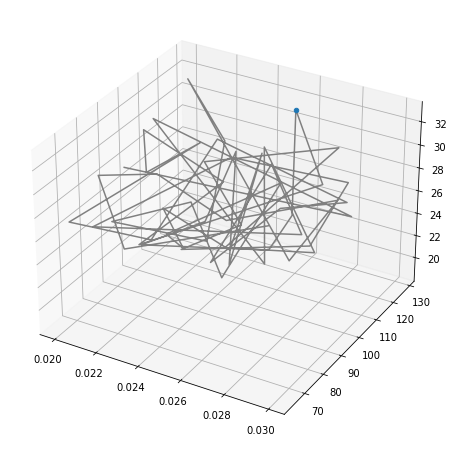

In [61]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_first_first
xline = learning_rate_first_first
yline = batch_first_first

maxlearning = max(rmse_inverse_first_first)
xmax = xline[rmse_inverse_first_first.index(maxlearning)]
ymax = yline[rmse_inverse_first_first.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [42]:
learning_rate_first_first

[0.02720324493442158,
 0.0230233257263184,
 0.02092338594768798,
 0.023455607270430476,
 0.025388167340033567,
 0.023347736395700862,
 0.03,
 0.026288117640027624,
 0.02758691337562565,
 0.021614581718546202,
 0.028807490504668062,
 0.023520196209863356,
 0.023928756964719123,
 0.027020481994531945,
 0.024066836824442297,
 0.028691224173438917,
 0.02716977150624074,
 0.023869086928756177,
 0.02570878862733933,
 0.026841042614089018,
 0.027889402367088915,
 0.029001624923226332,
 0.021987304047438296,
 0.028328262397047527,
 0.028394900039326595,
 0.026097204168460963,
 0.027685545161228103,
 0.026627006885265293,
 0.02487979895010642,
 0.025374092625049173,
 0.022144510316109402,
 0.025233644266538284,
 0.028526209217808046,
 0.022199843473008147,
 0.022981388333726344,
 0.029457878778571568,
 0.028813489106521588,
 0.026022259406767157,
 0.024703881770821022,
 0.028654814634575587,
 0.027312052613221532,
 0.024566070201797637,
 0.028402702270658796,
 0.028090163860953338,
 0.025274064

In [43]:
batch_first_first

[90.68940830096474,
 64.00731998831007,
 73.39237701229524,
 75.92065352817093,
 89.39311835076288,
 72.75681977953997,
 74.12007126822027,
 73.55562964311869,
 69.50861427399062,
 89.32015437822473,
 73.32859814730887,
 91.6668268154178,
 103.03356874600492,
 99.40488392259589,
 73.50047006612226,
 73.38590901956172,
 73.41122722268454,
 72.79581327977695,
 73.41343735410345,
 74.75689087784812,
 73.40149326859255,
 72.76950859897731,
 72.75083999506376,
 78.04695099655324,
 72.74769130806875,
 118.02250845234147,
 114.65611850970018,
 72.74045033393327,
 93.53231988845232,
 78.05819149094631,
 84.11764676309734,
 78.03717443365312,
 78.02297976397449,
 78.02811180320376,
 111.2744172096985,
 106.61568892497661,
 78.23380214913033,
 78.00854716012915,
 121.29452744300234,
 91.65891933359768,
 73.41129059400072,
 123.26177955379552,
 120.46898114126049,
 103.11669721398432,
 68.00849620454784,
 85.96979474210784,
 110.541926360263,
 112.09524374221081,
 74.15406498679552,
 82.724662474

In [44]:
rmse_inverse_first_first

[28.8611845565709,
 28.93824862173499,
 33.6397553580179,
 27.556712034591847,
 28.680397683300953,
 31.97293083616487,
 28.44908158679652,
 28.988637716657163,
 28.681783745095203,
 28.359666650096667,
 28.989029336000605,
 28.97850270692172,
 23.46936172641815,
 2.974225701758058,
 28.954066230339297,
 28.97740161847619,
 32.09752027650448,
 28.434396269849444,
 28.788243764829993,
 28.979236460636162,
 28.98826056077767,
 28.961515196465438,
 34.05269620338074,
 32.25851175351895,
 34.15821292189616,
 28.959576683886194,
 28.973922045338675,
 28.778948612571718,
 28.878119754800835,
 28.96314969951242,
 28.98799765233188,
 34.423593647820844,
 33.47753673050229,
 28.834623032637687,
 28.683083723260584,
 28.55927495371209,
 28.904817777739858,
 32.53124708467595,
 28.300431139739878,
 28.84306421215954,
 27.045089067719285,
 28.904754425382297,
 28.80848770588933,
 22.864850932831985,
 28.684698195858687,
 28.380201625467954,
 29.952540955216108,
 29.00614060574163,
 28.292999649160

In [96]:
rmse_inverse_first_first_max = max(rmse_inverse_first_first)
learning_rate_first_first_max = learning_rate_first_first[rmse_inverse_first_first.index(rmse_inverse_first_first_max)]
batch_first_first_max = batch_first_first[rmse_inverse_first_first.index(rmse_inverse_first_first_max)]

In [97]:
learning_rate_first_first_test = []
batch_first_first_test = []
rmse_inverse_first_first_test = []
def objective_function_RMSE_first_first_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_first_first_test.append(learning_rate)
    batch_first_first_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_first_first_test.append(1/rmse_lstm)
    return 1/rmse_lstm

In [98]:
optimizer_RMSE_first_first_test =BayesianOptimization(f=objective_function_RMSE_first_first_test,
    pbounds={'learning_rate': (learning_rate_first_first_max-0.001, learning_rate_first_first_max+0.001), 
             'batch_size':(batch_first_first_max-20, batch_first_first_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_first_first_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [94]:
rmse_inverse_first_first_test

[28.51209694292243,
 32.55141225177109,
 28.947449851201725,
 32.96655440550697,
 31.937304245603492,
 28.935147031605855,
 30.492459401023268,
 27.52760644860299]

In [95]:
rmse_inverse_first_first_max

34.423593647820844

In [118]:
print(rmse_inverse_first_first)
print(learning_rate_first_first)
print(batch_first_first)
print(rmse_inverse_first_first_test)
print(learning_rate_first_first_test)
print(batch_first_first_test)

[28.8611845565709, 28.93824862173499, 33.6397553580179, 27.556712034591847, 28.680397683300953, 31.97293083616487, 28.44908158679652, 28.988637716657163, 28.681783745095203, 28.359666650096667, 28.989029336000605, 28.97850270692172, 23.46936172641815, 2.974225701758058, 28.954066230339297, 28.97740161847619, 32.09752027650448, 28.434396269849444, 28.788243764829993, 28.979236460636162, 28.98826056077767, 28.961515196465438, 34.05269620338074, 32.25851175351895, 34.15821292189616, 28.959576683886194, 28.973922045338675, 28.778948612571718, 28.878119754800835, 28.96314969951242, 28.98799765233188, 34.423593647820844, 33.47753673050229, 28.834623032637687, 28.683083723260584, 28.55927495371209, 28.904817777739858, 32.53124708467595, 28.300431139739878, 28.84306421215954, 27.045089067719285, 28.904754425382297, 28.80848770588933, 22.864850932831985, 28.684698195858687, 28.380201625467954, 29.952540955216108, 29.00614060574163, 28.292999649160084, 28.78588951276742, 28.59178740950726, 27.57

Group 2, learning rate 0.02-0.03, batch size 128-256

In [19]:
learning_rate_first_second = []
batch_first_second = []
rmse_inverse_first_second = []
def objective_function_RMSE_first_second(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_first_second.append(learning_rate)
    batch_first_second.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_first_second.append(1/rmse_lstm)
    return 1/rmse_lstm

In [20]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_first_second,
    pbounds={'learning_rate': (0.02, 0.03), 'batch_size':(128, 256)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.022331829378090615
178.80337121248775
32.722379557085645


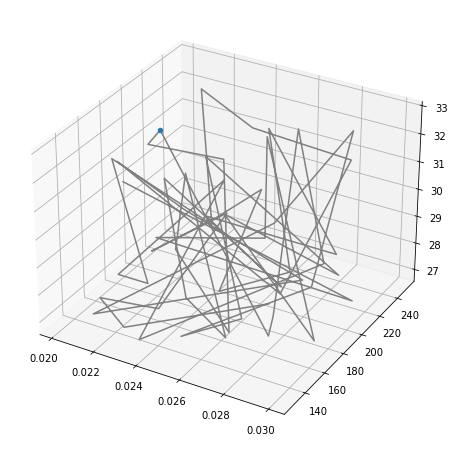

In [62]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_first_second
xline = learning_rate_first_second
yline = batch_first_second

maxlearning = max(rmse_inverse_first_second)
xmax = xline[rmse_inverse_first_second.index(maxlearning)]
ymax = yline[rmse_inverse_first_second.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [45]:
learning_rate_first_second


[0.02720324493442158,
 0.0230233257263184,
 0.02092338594768798,
 0.023455607270430476,
 0.025388167340033567,
 0.03,
 0.025226262490732027,
 0.022951222772677766,
 0.02032194608131121,
 0.02741913496884992,
 0.02778204481057432,
 0.02,
 0.023187807728214306,
 0.024826024686419063,
 0.029681639971422962,
 0.03,
 0.02690170973562435,
 0.024132794467985462,
 0.03,
 0.02580024406476232,
 0.024700301215417192,
 0.0267822069010418,
 0.028710834850836926,
 0.023225029068029188,
 0.027785502795617183,
 0.026097204168460963,
 0.027685545161228103,
 0.023649869265482504,
 0.02487979895010642,
 0.02091263025612657,
 0.022144510316109402,
 0.021321144137208887,
 0.020276154546936893,
 0.023896816894595208,
 0.022981388333726344,
 0.029457878778571568,
 0.028813489106521588,
 0.02647749299110956,
 0.024703881770821022,
 0.028654814634575587,
 0.02138205077200987,
 0.022012568250823584,
 0.028402702270658796,
 0.028090163860953338,
 0.025274064110697887,
 0.026392842931545882,
 0.022414684235866,
 

In [46]:
batch_first_second


[181.3788166019295,
 128.01463997662015,
 146.78475402459048,
 151.84130705634186,
 178.78623670152575,
 198.40650005675852,
 163.5371898847373,
 255.97074095009208,
 244.86133406225753,
 237.62927830008843,
 248.81695237016322,
 243.1551553005403,
 184.83825653059114,
 188.34017427689804,
 154.9684387887608,
 175.31874575899568,
 183.23671425351756,
 142.94810565104166,
 149.42267181543028,
 157.71911401948884,
 217.99869845650545,
 227.83347222790474,
 153.4356198268687,
 244.04923877185607,
 193.3241510746556,
 236.04501690468294,
 229.31223701940036,
 129.32390189317417,
 187.06463977690464,
 191.28688842344536,
 168.23529352619468,
 240.68332399289875,
 130.96880904527774,
 135.97329695856646,
 222.548834419397,
 213.23137784995322,
 156.46760429826065,
 138.8740958968909,
 242.58905488600467,
 183.31783866719536,
 131.57145990968795,
 191.03160006202648,
 240.93796228252097,
 206.23339442796865,
 136.01699240909568,
 171.93958948421567,
 221.083852720526,
 224.19048748442162,
 14

In [47]:
rmse_inverse_first_second

[33.83683495461864,
 30.59446424904762,
 32.59062512984186,
 33.27991800402961,
 33.52944675524357,
 28.9570570545403,
 28.60521872549264,
 32.53150708104679,
 34.53797997553491,
 28.98742906431094,
 28.98205877947167,
 34.19833305055517,
 34.25109929477178,
 28.927719195211974,
 33.23285073764006,
 28.959908561288316,
 33.26659549164874,
 31.02279301869554,
 31.266102172559613,
 28.855810366009514,
 28.842368892106823,
 28.9682482287187,
 28.745444630144664,
 28.960076174811906,
 28.929278513199677,
 33.29112622729704,
 28.84507667541575,
 33.33733642296761,
 31.888943376696105,
 34.611148205125055,
 28.939859890128115,
 33.744749377874804,
 31.87265470203683,
 33.27755950974613,
 33.5864230223101,
 28.925513274764327,
 28.974427000456867,
 28.30718434728818,
 28.94225113856493,
 32.9142963733681,
 32.33001313987801,
 33.55095968661187,
 28.977331424303888,
 28.511074562220738,
 28.884530991594236,
 31.935127508727444,
 31.128010901989683,
 31.725535331129155,
 28.891387582451948,
 28

In [102]:
rmse_inverse_first_second_max = max(rmse_inverse_first_second)
learning_rate_first_second_max = learning_rate_first_second[rmse_inverse_first_second.index(rmse_inverse_first_second_max)]
batch_first_second_max = batch_first_second[rmse_inverse_first_second.index(rmse_inverse_first_second_max)]

In [103]:
learning_rate_first_second_test = []
batch_first_second_test = []
rmse_inverse_first_second_test = []
def objective_function_RMSE_first_second_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_first_second_test.append(learning_rate)
    batch_first_second_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_first_second_test.append(1/rmse_lstm)
    return 1/rmse_lstm

In [104]:
optimizer_RMSE_first_second_test =BayesianOptimization(f=objective_function_RMSE_first_second_test,
    pbounds={'learning_rate': (learning_rate_first_second_max-0.001, learning_rate_first_second_max+0.001), 
             'batch_size':(batch_first_second_max-20, batch_first_second_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_first_second_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [119]:
print(rmse_inverse_first_second)
print(learning_rate_first_second)
print(batch_first_second)
print(rmse_inverse_first_second_test)
print(learning_rate_first_second_test)
print(batch_first_second_test)

[33.83683495461864, 30.59446424904762, 32.59062512984186, 33.27991800402961, 33.52944675524357, 28.9570570545403, 28.60521872549264, 32.53150708104679, 34.53797997553491, 28.98742906431094, 28.98205877947167, 34.19833305055517, 34.25109929477178, 28.927719195211974, 33.23285073764006, 28.959908561288316, 33.26659549164874, 31.02279301869554, 31.266102172559613, 28.855810366009514, 28.842368892106823, 28.9682482287187, 28.745444630144664, 28.960076174811906, 28.929278513199677, 33.29112622729704, 28.84507667541575, 33.33733642296761, 31.888943376696105, 34.611148205125055, 28.939859890128115, 33.744749377874804, 31.87265470203683, 33.27755950974613, 33.5864230223101, 28.925513274764327, 28.974427000456867, 28.30718434728818, 28.94225113856493, 32.9142963733681, 32.33001313987801, 33.55095968661187, 28.977331424303888, 28.511074562220738, 28.884530991594236, 31.935127508727444, 31.128010901989683, 31.725535331129155, 28.891387582451948, 28.92886688393762, 28.697627948172084, 28.893613669

Group 3, learning rate 0.03-0.04, batch size 64-128

In [21]:
learning_rate_second_first = []
batch_second_first = []
rmse_inverse_second_first = []
def objective_function_RMSE_second_first(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_second_first.append(learning_rate)
    batch_second_first.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_second_first.append(1/rmse_lstm)
    return 1/rmse_lstm

In [22]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_second_first,
    pbounds={'learning_rate': (0.03, 0.04), 'batch_size':(64, 128)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.031755675911876266
121.16471885405859
30.26144885793303


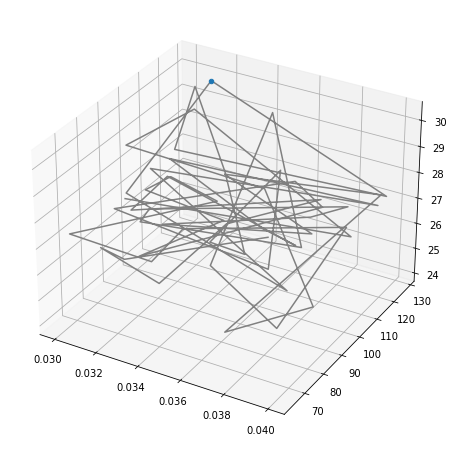

In [63]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_second_first
xline = learning_rate_second_first
yline = batch_second_first

maxlearning = max(rmse_inverse_second_first)
xmax = xline[rmse_inverse_second_first.index(maxlearning)]
ymax = yline[rmse_inverse_second_first.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [48]:
learning_rate_second_first

[0.03720324493442158,
 0.0330233257263184,
 0.030923385947687978,
 0.033455607270430475,
 0.03538816734003357,
 0.03201937758733733,
 0.036464295490624826,
 0.03995743368778422,
 0.039008246117231436,
 0.03293625687721511,
 0.03,
 0.030180693718067572,
 0.03409790261235773,
 0.037020481994531944,
 0.034066836824442295,
 0.033814683445827214,
 0.032748939351076124,
 0.03673457486681595,
 0.03416067618701094,
 0.03684104261408902,
 0.03399897674391201,
 0.03627158927684146,
 0.03374879156400456,
 0.03832826239704753,
 0.03778550279561718,
 0.03609720416846096,
 0.0376855451612281,
 0.0336498692654825,
 0.03487979895010642,
 0.030912630256126568,
 0.032144510316109404,
 0.031321144137208885,
 0.03027615454693689,
 0.03389681689459521,
 0.03298138833372634,
 0.03945787877857157,
 0.03881348910652159,
 0.03647749299110956,
 0.034703881770821024,
 0.03865481463457559,
 0.03138205077200987,
 0.03456607020179764,
 0.0384027022706588,
 0.03809016386095334,
 0.03527406411069789,
 0.0363928429315

In [49]:
batch_second_first

[90.68940830096474,
 64.00731998831007,
 73.39237701229524,
 75.92065352817093,
 89.39311835076288,
 72.40670874615385,
 92.46011001942297,
 95.3423775155768,
 96.78925013138323,
 98.73017886191641,
 99.67142027877738,
 98.42786669256216,
 99.00514596160826,
 99.40488392259589,
 73.50047006612226,
 98.73482232414065,
 85.70872864997332,
 76.22033274718517,
 122.22544759172087,
 74.75689087784812,
 109.88839544414829,
 69.10313191136711,
 64.70339803363655,
 78.04695099655324,
 96.6620755373278,
 118.02250845234147,
 114.65611850970018,
 64.66195094658708,
 93.53231988845232,
 95.64344421172268,
 84.11764676309734,
 120.34166199644937,
 65.48440452263887,
 67.98664847928323,
 111.2744172096985,
 106.61568892497661,
 78.23380214913033,
 69.43704794844545,
 121.29452744300234,
 91.65891933359768,
 65.78572995484397,
 123.26177955379552,
 120.46898114126049,
 103.11669721398432,
 68.00849620454784,
 85.96979474210784,
 110.541926360263,
 112.09524374221081,
 74.15406498679552,
 82.72466247

In [50]:
rmse_inverse_second_first

[28.574051958088948,
 27.98682803440051,
 28.870166700013964,
 25.69816159313579,
 28.105274860713973,
 28.461245248088932,
 28.204238299262553,
 28.916140524243193,
 28.907589912024548,
 32.43125257031901,
 28.91082729505392,
 30.791292980278254,
 27.045109930872773,
 28.70175775478497,
 28.89964417976294,
 28.128551940019882,
 28.886830522572907,
 28.875375959547572,
 28.849174516399312,
 21.45405523388468,
 28.387698091223964,
 27.78174994398383,
 28.986915422188915,
 28.51156472459566,
 28.52474297132086,
 28.43718906904097,
 27.955287567256683,
 28.94293940081464,
 28.656290697635495,
 28.988253938459195,
 28.248810930260056,
 33.087281645168396,
 28.80812745038254,
 28.883595887998776,
 28.37632414260292,
 28.834442421515238,
 27.681323948453844,
 28.872539901258943,
 28.876653417836717,
 28.989571147294576,
 28.342995673029453,
 28.73969349218427,
 28.969238177571977,
 28.971393806691914,
 28.680631985634093,
 28.98928937133012,
 28.980970471640134,
 28.938911141652998,
 27.7395

In [105]:
rmse_inverse_second_first_max = max(rmse_inverse_second_first)
learning_rate_second_first_max = learning_rate_second_first[rmse_inverse_second_first.index(rmse_inverse_second_first_max)]
batch_second_first_max = batch_second_first[rmse_inverse_second_first.index(rmse_inverse_second_first_max)]

learning_rate_second_first_test = []
batch_second_first_test = []
rmse_inverse_second_first_test = []
def objective_function_RMSE_second_first_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_second_first_test.append(learning_rate)
    batch_second_first_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_second_first_test.append(1/rmse_lstm)
    return 1/rmse_lstm

optimizer_RMSE_second_first_test =BayesianOptimization(f=objective_function_RMSE_second_first_test,
    pbounds={'learning_rate': (learning_rate_second_first_max-0.001, learning_rate_second_first_max+0.001), 
             'batch_size':(batch_second_first_max-20, batch_second_first_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_second_first_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [120]:
print(rmse_inverse_second_first)
print(learning_rate_second_first)
print(batch_second_first)
print(rmse_inverse_second_first_test)
print(learning_rate_second_first_test)
print(batch_second_first_test)

[28.574051958088948, 27.98682803440051, 28.870166700013964, 25.69816159313579, 28.105274860713973, 28.461245248088932, 28.204238299262553, 28.916140524243193, 28.907589912024548, 32.43125257031901, 28.91082729505392, 30.791292980278254, 27.045109930872773, 28.70175775478497, 28.89964417976294, 28.128551940019882, 28.886830522572907, 28.875375959547572, 28.849174516399312, 21.45405523388468, 28.387698091223964, 27.78174994398383, 28.986915422188915, 28.51156472459566, 28.52474297132086, 28.43718906904097, 27.955287567256683, 28.94293940081464, 28.656290697635495, 28.988253938459195, 28.248810930260056, 33.087281645168396, 28.80812745038254, 28.883595887998776, 28.37632414260292, 28.834442421515238, 27.681323948453844, 28.872539901258943, 28.876653417836717, 28.989571147294576, 28.342995673029453, 28.73969349218427, 28.969238177571977, 28.971393806691914, 28.680631985634093, 28.98928937133012, 28.980970471640134, 28.938911141652998, 27.739560773398644, 28.921993934459884, 28.985174080762

Group 4, learning rate 0.03-0.04, batch size 128-256

In [23]:
learning_rate_second_second = []
batch_second_second = []
rmse_inverse_second_second = []
def objective_function_RMSE_second_second(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_second_second.append(learning_rate)
    batch_second_second.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_second_second.append(1/rmse_lstm)
    return 1/rmse_lstm

In [24]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_second_second,
    pbounds={'learning_rate': (0.03, 0.04), 'batch_size':(128, 256)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.03794973145135077
181.37787614988153
31.480946186186117


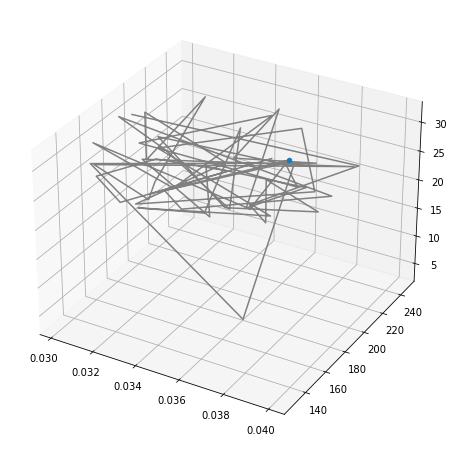

In [64]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_second_second
xline = learning_rate_second_second
yline = batch_second_second

maxlearning = max(rmse_inverse_second_second)
xmax = xline[rmse_inverse_second_second.index(maxlearning)]
ymax = yline[rmse_inverse_second_second.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [51]:
learning_rate_second_second 

[0.03720324493442158,
 0.0330233257263184,
 0.030923385947687978,
 0.033455607270430475,
 0.03538816734003357,
 0.03479074500835936,
 0.03,
 0.03447634027669317,
 0.03758691337562565,
 0.039306952575330394,
 0.03447200249612971,
 0.03352019620986336,
 0.03225880708462524,
 0.037020481994531944,
 0.034066836824442295,
 0.0353428686921468,
 0.032748939351076124,
 0.03673457486681595,
 0.03416067618701094,
 0.03684104261408902,
 0.03399897674391201,
 0.03627158927684146,
 0.03374879156400456,
 0.03832826239704753,
 0.03778550279561718,
 0.03609720416846096,
 0.0376855451612281,
 0.0336498692654825,
 0.03487979895010642,
 0.030912630256126568,
 0.032144510316109404,
 0.031321144137208885,
 0.03027615454693689,
 0.03389681689459521,
 0.03298138833372634,
 0.03945787877857157,
 0.03881348910652159,
 0.03647749299110956,
 0.034703881770821024,
 0.03865481463457559,
 0.03138205077200987,
 0.03456607020179764,
 0.0384027022706588,
 0.03809016386095334,
 0.03527406411069789,
 0.03639284293154588

In [52]:
batch_second_second

[181.3788166019295,
 128.01463997662015,
 146.78475402459048,
 151.84130705634186,
 178.78623670152575,
 186.06550872333077,
 135.06362957716243,
 138.1874973233476,
 139.01722854798123,
 134.1861975407415,
 241.6252199752331,
 183.3336536308356,
 183.3410314633063,
 198.80976784519177,
 147.00094013224452,
 136.5513480116846,
 171.41745729994665,
 152.44066549437034,
 244.45089518344173,
 149.51378175569624,
 219.77679088829657,
 138.20626382273423,
 129.4067960672731,
 156.09390199310647,
 193.3241510746556,
 236.04501690468294,
 229.31223701940036,
 129.32390189317417,
 187.06463977690464,
 191.28688842344536,
 168.23529352619468,
 240.68332399289875,
 130.96880904527774,
 135.97329695856646,
 222.548834419397,
 213.23137784995322,
 156.46760429826065,
 138.8740958968909,
 242.58905488600467,
 183.31783866719536,
 131.57145990968795,
 246.52355910759104,
 240.93796228252097,
 206.23339442796865,
 136.01699240909568,
 171.93958948421567,
 221.083852720526,
 224.19048748442162,
 148.3

In [53]:
rmse_inverse_second_second

[28.961265962172813,
 28.96355982964731,
 28.68894734074426,
 28.51473481950761,
 28.815304798103234,
 28.988983007245423,
 30.651431034908548,
 28.81139180704164,
 28.94839761178263,
 28.647730102773984,
 28.985045706339218,
 31.481328920830673,
 28.959976894195798,
 28.950736187775973,
 28.989610799748817,
 28.984336902498246,
 28.989351766569683,
 32.768881372728984,
 28.987211941985883,
 28.958341097662526,
 33.093592428602506,
 28.4814577481987,
 28.59058739358705,
 28.648030355793164,
 28.92716508834396,
 28.94384025908351,
 28.98953666644354,
 28.95260823402869,
 28.685320212745623,
 33.02955182686943,
 28.856303625184708,
 31.869755219041902,
 28.599821582218915,
 28.58563548637867,
 33.453402180324375,
 32.7121603001645,
 28.512656243102253,
 31.04041746277005,
 31.94946467488734,
 28.904527430284652,
 28.807442669295167,
 28.958497651887274,
 28.953539302017695,
 28.07090072347039,
 28.935202250255745,
 33.722876293016895,
 28.976248966819327,
 28.677793152877786,
 34.9943678

In [106]:
rmse_inverse_second_second_max = max(rmse_inverse_second_second)
learning_rate_second_second_max = learning_rate_second_second[rmse_inverse_second_second.index(
    rmse_inverse_second_second_max)]
batch_second_second_max = batch_second_second[rmse_inverse_second_second.index(rmse_inverse_second_second_max)]

learning_rate_second_second_test = []
batch_second_second_test = []
rmse_inverse_second_second_test = []
def objective_function_RMSE_second_second_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_second_second_test.append(learning_rate)
    batch_second_second_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_second_second_test.append(1/rmse_lstm)
    return 1/rmse_lstm

optimizer_RMSE_second_second_test =BayesianOptimization(f=objective_function_RMSE_second_second_test,
    pbounds={'learning_rate': (learning_rate_second_second_max-0.001, learning_rate_second_second_max+0.001), 
             'batch_size':(batch_second_second_max-20, batch_second_second_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_second_second_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [121]:
print(rmse_inverse_second_second)
print(learning_rate_second_second)
print(batch_second_second)
print(rmse_inverse_second_second_test)
print(learning_rate_second_second_test)
print(batch_second_second_test)

[28.961265962172813, 28.96355982964731, 28.68894734074426, 28.51473481950761, 28.815304798103234, 28.988983007245423, 30.651431034908548, 28.81139180704164, 28.94839761178263, 28.647730102773984, 28.985045706339218, 31.481328920830673, 28.959976894195798, 28.950736187775973, 28.989610799748817, 28.984336902498246, 28.989351766569683, 32.768881372728984, 28.987211941985883, 28.958341097662526, 33.093592428602506, 28.4814577481987, 28.59058739358705, 28.648030355793164, 28.92716508834396, 28.94384025908351, 28.98953666644354, 28.95260823402869, 28.685320212745623, 33.02955182686943, 28.856303625184708, 31.869755219041902, 28.599821582218915, 28.58563548637867, 33.453402180324375, 32.7121603001645, 28.512656243102253, 31.04041746277005, 31.94946467488734, 28.904527430284652, 28.807442669295167, 28.958497651887274, 28.953539302017695, 28.07090072347039, 28.935202250255745, 33.722876293016895, 28.976248966819327, 28.677793152877786, 34.99436783429374, 28.88619631489732, 28.90642789462819, 2

Group 5, learning rate 0.04-0.05, batch size 64-128

In [25]:
learning_rate_third_first = []
batch_third_first = []
rmse_inverse_third_first = []
def objective_function_RMSE_third_first(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_third_first.append(learning_rate)
    batch_third_first.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_third_first.append(1/rmse_lstm)
    return 1/rmse_lstm

In [26]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_third_first,
    pbounds={'learning_rate': (0.04, 0.05), 'batch_size':(64, 128)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.04720324493442159
90.68940830096474
27.50251431025215


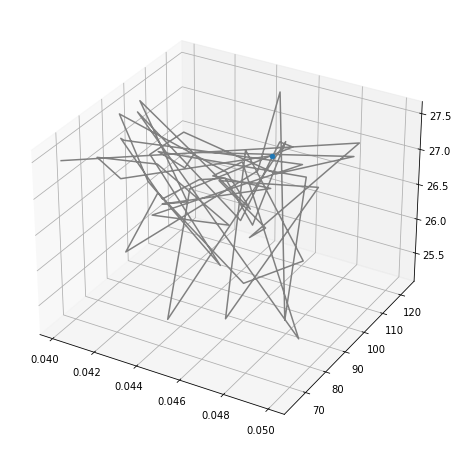

In [65]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_third_first
xline = learning_rate_third_first
yline = batch_third_first

maxlearning = max(rmse_inverse_third_first)
xmax = xline[rmse_inverse_third_first.index(maxlearning)]
ymax = yline[rmse_inverse_third_first.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [54]:
learning_rate_third_first


[0.04720324493442159,
 0.043023325726318395,
 0.040923385947687976,
 0.04345560727043048,
 0.04538816734003357,
 0.04788327005034417,
 0.04,
 0.049009201605228536,
 0.04367221211396992,
 0.045823526121132385,
 0.049334735160522086,
 0.04191786246380168,
 0.04258827893458221,
 0.047166915888554914,
 0.04905499226024472,
 0.040617471752869366,
 0.04,
 0.05,
 0.04,
 0.043883241754409816,
 0.04,
 0.04321682129379825,
 0.05,
 0.04,
 0.0438764742306454,
 0.04,
 0.040490479384885945,
 0.043649869265482505,
 0.04487979895010642,
 0.04091263025612657,
 0.042144510316109406,
 0.04132114413720889,
 0.04027615454693689,
 0.04389681689459521,
 0.04298138833372635,
 0.049457878778571565,
 0.04881348910652159,
 0.04686365990675361,
 0.04833165465225611,
 0.04188014856370595,
 0.04964956035781228,
 0.043352082238033066,
 0.0484027022706588,
 0.04,
 0.04385044045630085,
 0.04622664600778968,
 0.0490342290683829,
 0.05,
 0.0408898607122079,
 0.04633206924953261,
 0.045905612768618556,
 0.05,
 0.04874295

In [55]:
batch_third_first


[90.68940830096474,
 64.00731998831007,
 73.39237701229524,
 75.92065352817093,
 89.39311835076288,
 87.95315381689757,
 70.57038552684526,
 85.55186756803184,
 122.63168647411027,
 120.66617156796019,
 123.78590771808699,
 126.29487655935563,
 127.99421306068994,
 125.27262668957803,
 66.3221785846983,
 104.72165131524937,
 95.95085712906628,
 113.35061379584172,
 116.16050994881138,
 81.78177532170442,
 110.49125647491907,
 99.52541239508648,
 100.99998772379982,
 93.07178642811596,
 118.00609196076766,
 118.53344902219116,
 117.71740470315865,
 64.66195094658708,
 93.53231988845232,
 95.64344421172268,
 84.11764676309734,
 120.34166199644937,
 65.48440452263887,
 67.98664847928323,
 111.2744172096985,
 106.61568892497661,
 78.23380214913033,
 108.24261563644623,
 114.81778586029247,
 102.56165425472962,
 103.31694992028517,
 101.94638590469873,
 120.46898114126049,
 98.07542571913332,
 72.00237225645294,
 69.2256510978279,
 86.78373367550158,
 74.59485852919447,
 94.61101240547009,


In [56]:
rmse_inverse_third_first

[28.585191747769944,
 28.651280832746256,
 28.64243602165244,
 27.43164335771186,
 28.87844440467118,
 28.960872119891732,
 28.44508137438829,
 28.519349079288165,
 28.988743053663363,
 28.100772623860344,
 28.85735807962448,
 28.930229543920994,
 27.440285652176865,
 28.98925283370328,
 27.92311249014004,
 26.08350352737849,
 27.956402562811874,
 28.636738163591737,
 28.66867879284145,
 27.67227773175269,
 28.087434289499974,
 28.989328973609577,
 28.848475327551352,
 28.755068931741565,
 31.7044893242364,
 29.866983026785647,
 28.52496596477887,
 27.94732330087526,
 28.84272103969076,
 28.95676803187535,
 27.503818692447084,
 28.469658166824136,
 28.54339248726048,
 28.944063819819107,
 28.915817254120316,
 28.989278636875422,
 2.976615958032124,
 28.98135487405113,
 28.981482513474628,
 33.121265198024126,
 26.976513926932245,
 28.93760976759893,
 28.66696196049099,
 28.531178358603583,
 28.74711274228852,
 28.72740583330976,
 28.80401645301268,
 22.937140453798516,
 28.976717995805

In [107]:
rmse_inverse_third_first_max = max(rmse_inverse_third_first)
learning_rate_third_first_max = learning_rate_third_first[rmse_inverse_third_first.index(
    rmse_inverse_third_first_max)]
batch_third_first_max = batch_third_first[rmse_inverse_third_first.index(rmse_inverse_third_first_max)]

learning_rate_third_first_test = []
batch_third_first_test = []
rmse_inverse_third_first_test = []
def objective_function_RMSE_third_first_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_third_first_test.append(learning_rate)
    batch_third_first_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_third_first_test.append(1/rmse_lstm)
    return 1/rmse_lstm

optimizer_RMSE_third_first_test =BayesianOptimization(f=objective_function_RMSE_third_first_test,
    pbounds={'learning_rate': (learning_rate_third_first_max-0.001, learning_rate_third_first_max+0.001), 
             'batch_size':(batch_third_first_max-20, batch_third_first_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_third_first_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [122]:
print(rmse_inverse_third_first)
print(learning_rate_third_first)
print(batch_third_first)
print(rmse_inverse_third_first_test)
print(learning_rate_third_first_test)
print(batch_third_first_test)

[28.585191747769944, 28.651280832746256, 28.64243602165244, 27.43164335771186, 28.87844440467118, 28.960872119891732, 28.44508137438829, 28.519349079288165, 28.988743053663363, 28.100772623860344, 28.85735807962448, 28.930229543920994, 27.440285652176865, 28.98925283370328, 27.92311249014004, 26.08350352737849, 27.956402562811874, 28.636738163591737, 28.66867879284145, 27.67227773175269, 28.087434289499974, 28.989328973609577, 28.848475327551352, 28.755068931741565, 31.7044893242364, 29.866983026785647, 28.52496596477887, 27.94732330087526, 28.84272103969076, 28.95676803187535, 27.503818692447084, 28.469658166824136, 28.54339248726048, 28.944063819819107, 28.915817254120316, 28.989278636875422, 2.976615958032124, 28.98135487405113, 28.981482513474628, 33.121265198024126, 26.976513926932245, 28.93760976759893, 28.66696196049099, 28.531178358603583, 28.74711274228852, 28.72740583330976, 28.80401645301268, 22.937140453798516, 28.976717995805497, 28.988577459889438, 28.305178310615016, 28.

Group 6, learning rate 0.04-0.05, batch size 128-256

In [27]:
learning_rate_third_second = []
batch_third_second = []
rmse_inverse_third_second = []
def objective_function_RMSE_third_second(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_third_second.append(learning_rate)
    batch_third_second.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_third_second.append(1/rmse_lstm)
    return 1/rmse_lstm

In [28]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_third_second,
    pbounds={'learning_rate': (0.04, 0.05), 'batch_size':(128, 256)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.0440668368244423
147.00094013224452
32.04218720383687


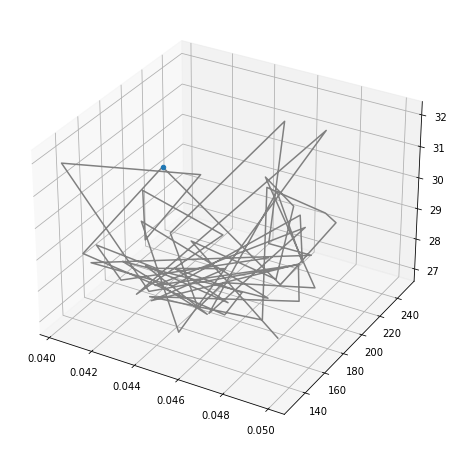

In [57]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_third_second
xline = learning_rate_third_second
yline = batch_third_second

maxlearning = max(rmse_inverse_third_second)
xmax = xline[rmse_inverse_third_second.index(maxlearning)]
ymax = yline[rmse_inverse_third_second.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [58]:
rmse_inverse_third_second

[28.88621900899112,
 28.843141387479292,
 28.98437493775448,
 28.61688734997081,
 28.232557271117393,
 27.914889098205908,
 28.973840987360973,
 27.78915397841623,
 28.597508867444702,
 28.96055674753971,
 28.959603694037362,
 28.656654638169066,
 28.437996973989513,
 27.466707089228056,
 32.04218720383687,
 28.565540878680824,
 27.989418429268873,
 28.86444572433627,
 28.98666803589214,
 28.309715279592435,
 28.78904091986042,
 28.604642628131167,
 28.712135954815984,
 28.579025386595653,
 28.864584196687797,
 26.957446031953594,
 31.722442962053297,
 28.490801882037662,
 28.98399448213151,
 29.51731802548917,
 28.793520460489635,
 28.798223428615735,
 31.854403930215934,
 28.43682422816446,
 28.97207367231172,
 28.244095695141382,
 28.440936409128245,
 28.211073086100075,
 28.916133262488415,
 28.989303220096335,
 28.796279581515485,
 28.412473582128516,
 28.986689911494775,
 28.442242141661666,
 28.978477228022484,
 31.66286007368619,
 28.543214622009092,
 28.717064232629987,
 28.95

In [59]:
learning_rate_third_second

[0.04720324493442159,
 0.043023325726318395,
 0.040923385947687976,
 0.04345560727043048,
 0.04538816734003357,
 0.04368879169973435,
 0.048564851019971586,
 0.04862183763857458,
 0.044321095340445225,
 0.04932390269475751,
 0.04447200249612971,
 0.04722410442246506,
 0.04773003710977532,
 0.047020481994531946,
 0.0440668368244423,
 0.040258121787296305,
 0.04680247373354966,
 0.04757675701849434,
 0.04453787360405801,
 0.04684104261408902,
 0.043205893494253064,
 0.04690770350205996,
 0.04214450441820735,
 0.04832826239704753,
 0.04131371502593604,
 0.04469534141470271,
 0.0476855451612281,
 0.043649869265482505,
 0.04487979895010642,
 0.04091263025612657,
 0.042144510316109406,
 0.04132114413720889,
 0.04027615454693689,
 0.04389681689459521,
 0.04862238280317935,
 0.04363103542912504,
 0.046824017807323794,
 0.046477492991109565,
 0.04494882508030314,
 0.04865481463457559,
 0.04657954252420127,
 0.04447041858993262,
 0.04148638405453752,
 0.04809016386095334,
 0.04679260550764426,
 

In [60]:
batch_third_second

[181.3788166019295,
 128.01463997662015,
 146.78475402459048,
 151.84130705634186,
 178.78623670152575,
 141.92336828963317,
 181.3788397873672,
 181.38785831794848,
 128.00938704178415,
 128.01938508978805,
 241.6252199752331,
 241.63047012842162,
 241.61752459506533,
 198.80976784519177,
 147.00094013224452,
 146.99319303133507,
 147.00907905401277,
 147.00392505761133,
 146.99699915855598,
 149.51378175569624,
 146.9965800594943,
 128.02526329611874,
 146.7781903293817,
 156.09390199310647,
 181.37311589713767,
 146.99789366000982,
 229.31223701940036,
 129.32390189317417,
 187.06463977690464,
 191.28688842344536,
 168.23529352619468,
 240.68332399289875,
 130.96880904527774,
 135.97329695856646,
 181.37879694903282,
 147.00356657974606,
 229.31349353681998,
 138.8740958968909,
 241.62214090104172,
 183.31783866719536,
 229.31249378975477,
 147.00258086344206,
 130.96702716307328,
 206.23339442796865,
 191.28672930471697,
 229.3111854034184,
 187.062820477924,
 128.0204430231671,
 1

In [108]:
rmse_inverse_third_second_max = max(rmse_inverse_third_second)
learning_rate_third_second_max = learning_rate_third_second[rmse_inverse_third_second.index(
    rmse_inverse_third_second_max)]
batch_third_second_max = batch_third_second[rmse_inverse_third_second.index(rmse_inverse_third_second_max)]

learning_rate_third_second_test = []
batch_third_second_test = []
rmse_inverse_third_second_test = []
def objective_function_RMSE_third_second_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_third_second_test.append(learning_rate)
    batch_third_second_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_third_second_test.append(1/rmse_lstm)
    return 1/rmse_lstm

optimizer_RMSE_third_second_test =BayesianOptimization(f=objective_function_RMSE_third_second_test,
    pbounds={'learning_rate': (learning_rate_third_second_max-0.001, learning_rate_third_second_max+0.001), 
             'batch_size':(batch_third_second_max-20, batch_third_second_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_third_second_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [123]:
print(rmse_inverse_third_second)
print(learning_rate_third_second)
print(batch_third_second)
print(rmse_inverse_third_second_test)
print(learning_rate_third_second_test)
print(batch_third_second_test)

[28.88621900899112, 28.843141387479292, 28.98437493775448, 28.61688734997081, 28.232557271117393, 27.914889098205908, 28.973840987360973, 27.78915397841623, 28.597508867444702, 28.96055674753971, 28.959603694037362, 28.656654638169066, 28.437996973989513, 27.466707089228056, 32.04218720383687, 28.565540878680824, 27.989418429268873, 28.86444572433627, 28.98666803589214, 28.309715279592435, 28.78904091986042, 28.604642628131167, 28.712135954815984, 28.579025386595653, 28.864584196687797, 26.957446031953594, 31.722442962053297, 28.490801882037662, 28.98399448213151, 29.51731802548917, 28.793520460489635, 28.798223428615735, 31.854403930215934, 28.43682422816446, 28.97207367231172, 28.244095695141382, 28.440936409128245, 28.211073086100075, 28.916133262488415, 28.989303220096335, 28.796279581515485, 28.412473582128516, 28.986689911494775, 28.442242141661666, 28.978477228022484, 31.66286007368619, 28.543214622009092, 28.717064232629987, 28.95200462468771, 28.984629671583967, 28.97060715026

Group 7, learning rate 0.01-0.02, batch size 64-128

In [29]:
learning_rate_fourth_first = []
batch_fourth_first = []
rmse_inverse_fourth_first = []
def objective_function_RMSE_fourth_first(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_fourth_first.append(learning_rate)
    batch_fourth_first.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_fourth_first.append(1/rmse_lstm)
    return 1/rmse_lstm

In [30]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_fourth_first,
    pbounds={'learning_rate': (0.01, 0.02), 'batch_size':(64, 128)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.01758691337562565
69.50861427399062
34.666938137512226


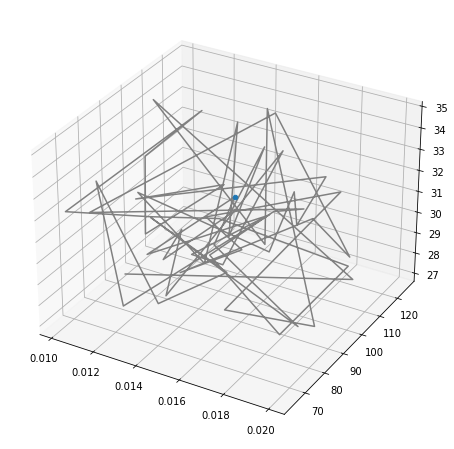

In [61]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_fourth_first
xline = learning_rate_fourth_first
yline = batch_fourth_first

maxlearning = max(rmse_inverse_fourth_first)
xmax = xline[rmse_inverse_fourth_first.index(maxlearning)]
ymax = yline[rmse_inverse_fourth_first.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [62]:
rmse_inverse_fourth_first

[32.03714318040483,
 28.735226472047184,
 33.16029619447745,
 27.931614009237137,
 28.866094063887793,
 32.47494846020241,
 27.146543469002708,
 31.783662298970174,
 34.666938137512226,
 28.585419970213586,
 28.740310880603555,
 28.968189778438006,
 27.619876695725676,
 34.23837770476623,
 28.717076846792352,
 32.65216097124477,
 28.987885737237526,
 33.09109610141851,
 31.894161645901658,
 32.23648354445145,
 33.95324049854418,
 31.30833250953153,
 34.142469915425124,
 31.70565209010942,
 32.78377328802386,
 28.95975557803639,
 32.03695698013343,
 33.82205284277427,
 32.535155804838055,
 28.843825754047653,
 33.82032980030399,
 33.01767960495885,
 32.19453537390861,
 32.82462029521969,
 28.929110425916956,
 28.95201325286424,
 27.97146172696172,
 31.723662765387004,
 28.96406542384677,
 32.64735699161007,
 32.45651924293966,
 33.54608695314183,
 27.889318080976622,
 31.0984515004849,
 30.664410124497117,
 30.546366220070787,
 28.902628837664697,
 31.780671266192908,
 28.82769138717868

In [63]:
learning_rate_fourth_first

[0.01720324493442158,
 0.013023325726318398,
 0.010923385947687977,
 0.013455607270430478,
 0.015388167340033568,
 0.01368879169973435,
 0.01856485101997158,
 0.016288117640027626,
 0.01758691337562565,
 0.011614581718546204,
 0.014472002496129708,
 0.013520196209863356,
 0.013928756964719123,
 0.017020481994531947,
 0.014066836824442298,
 0.015342868692146797,
 0.012748939351076127,
 0.016734574866815954,
 0.014160676187010942,
 0.01684104261408902,
 0.013998976743912006,
 0.016271589276841456,
 0.01374879156400456,
 0.01832826239704753,
 0.017785502795617185,
 0.016097204168460964,
 0.017685545161228104,
 0.013649869265482506,
 0.01487979895010642,
 0.010912630256126571,
 0.012144510316109403,
 0.011321144137208888,
 0.01027615454693689,
 0.01389681689459521,
 0.012981388333726343,
 0.019457878778571566,
 0.018813489106521586,
 0.01647749299110956,
 0.014703881770821024,
 0.018654814634575585,
 0.011382050772009869,
 0.014566070201797638,
 0.0184027022706588,
 0.018090163860953343,
 

In [64]:
batch_fourth_first

[90.68940830096474,
 64.00731998831007,
 73.39237701229524,
 75.92065352817093,
 89.39311835076288,
 70.96168414481659,
 90.6894198936836,
 73.55562964311869,
 69.50861427399062,
 89.32015437822473,
 120.81260998761655,
 91.6668268154178,
 103.03356874600492,
 99.40488392259589,
 73.50047006612226,
 68.2756740058423,
 85.70872864997332,
 76.22033274718517,
 122.22544759172087,
 74.75689087784812,
 109.88839544414829,
 69.10313191136711,
 64.70339803363655,
 78.04695099655324,
 96.6620755373278,
 118.02250845234147,
 114.65611850970018,
 64.66195094658708,
 93.53231988845232,
 95.64344421172268,
 84.11764676309734,
 120.34166199644937,
 65.48440452263887,
 67.98664847928323,
 111.2744172096985,
 106.61568892497661,
 78.23380214913033,
 69.43704794844545,
 121.29452744300234,
 91.65891933359768,
 65.78572995484397,
 123.26177955379552,
 120.46898114126049,
 103.11669721398432,
 68.00849620454784,
 85.96979474210784,
 110.541926360263,
 112.09524374221081,
 74.15406498679552,
 82.72466247

In [109]:
rmse_inverse_fourth_first_max = max(rmse_inverse_fourth_first)
learning_rate_fourth_first_max = learning_rate_fourth_first[rmse_inverse_fourth_first.index(
    rmse_inverse_fourth_first_max)]
batch_fourth_first_max = batch_fourth_first[rmse_inverse_fourth_first.index(rmse_inverse_fourth_first_max)]

learning_rate_fourth_first_test = []
batch_fourth_first_test = []
rmse_inverse_fourth_first_test = []
def objective_function_RMSE_fourth_first_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_fourth_first_test.append(learning_rate)
    batch_fourth_first_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_fourth_first_test.append(1/rmse_lstm)
    return 1/rmse_lstm

optimizer_RMSE_fourth_first_test =BayesianOptimization(f=objective_function_RMSE_fourth_first_test,
    pbounds={'learning_rate': (learning_rate_fourth_first_max-0.001, learning_rate_fourth_first_max+0.001), 
             'batch_size':(batch_fourth_first_max-20, batch_fourth_first_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_fourth_first_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [124]:
print(rmse_inverse_fourth_first)
print(learning_rate_fourth_first)
print(batch_fourth_first)
print(rmse_inverse_fourth_first_test)
print(learning_rate_fourth_first_test)
print(batch_fourth_first_test)

[32.03714318040483, 28.735226472047184, 33.16029619447745, 27.931614009237137, 28.866094063887793, 32.47494846020241, 27.146543469002708, 31.783662298970174, 34.666938137512226, 28.585419970213586, 28.740310880603555, 28.968189778438006, 27.619876695725676, 34.23837770476623, 28.717076846792352, 32.65216097124477, 28.987885737237526, 33.09109610141851, 31.894161645901658, 32.23648354445145, 33.95324049854418, 31.30833250953153, 34.142469915425124, 31.70565209010942, 32.78377328802386, 28.95975557803639, 32.03695698013343, 33.82205284277427, 32.535155804838055, 28.843825754047653, 33.82032980030399, 33.01767960495885, 32.19453537390861, 32.82462029521969, 28.929110425916956, 28.95201325286424, 27.97146172696172, 31.723662765387004, 28.96406542384677, 32.64735699161007, 32.45651924293966, 33.54608695314183, 27.889318080976622, 31.0984515004849, 30.664410124497117, 30.546366220070787, 28.902628837664697, 31.780671266192908, 28.827691387178685, 28.337550115718003, 33.45590335246885, 32.616

Group 8, learning rate 0.01-0.02, batch size 128-256

In [31]:
learning_rate_fourth_second = []
batch_fourth_second = []
rmse_inverse_fourth_second = []
def objective_function_RMSE_fourth_second(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_fourth_second.append(learning_rate)
    batch_fourth_second.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_fourth_second.append(1/rmse_lstm)
    return 1/rmse_lstm

In [32]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_fourth_second,
    pbounds={'learning_rate': (0.01, 0.02), 'batch_size':(128, 256)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.013625032602564341
139.4560993244441
35.046450171167606


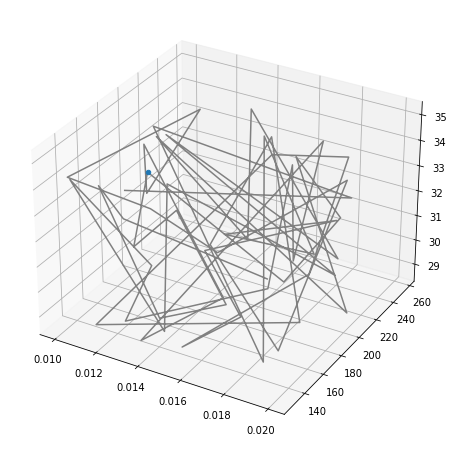

In [65]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_fourth_second
xline = learning_rate_fourth_second
yline = batch_fourth_second

maxlearning = max(rmse_inverse_fourth_second)
xmax = xline[rmse_inverse_fourth_second.index(maxlearning)]
ymax = yline[rmse_inverse_fourth_second.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [66]:
rmse_inverse_fourth_second

[30.39842210331541,
 33.50697864622672,
 33.66998573522391,
 28.879742267028327,
 28.977748645547706,
 33.6786811127584,
 32.33415941736033,
 35.046450171167606,
 28.968966429549354,
 33.100660506816574,
 34.70977917060811,
 28.980659106782504,
 34.112993968265584,
 33.718184820782426,
 33.84451859396329,
 28.93577093287505,
 32.82638115897608,
 28.781332231926633,
 31.02694287971995,
 28.90557673316568,
 33.95773785328234,
 28.751251854234248,
 28.921873161526197,
 31.186093862671573,
 34.598883673482845,
 28.966725571290414,
 34.38401164196619,
 28.84836255391038,
 28.83057002131477,
 33.89537236940383,
 32.975997513262264,
 33.89359924627508,
 34.34229007775244,
 33.840391260985065,
 28.98959259725184,
 33.770673008395924,
 28.840742541977757,
 33.0126648742354,
 33.48143550028122,
 28.954965629928537,
 28.79669199171828,
 32.61815048468297,
 33.56462715106276,
 29.94894447504218,
 28.78099746274829,
 28.985956000763238,
 28.986624173374526,
 31.632753529490728,
 33.14130539153992,


In [67]:
learning_rate_fourth_second

[0.01720324493442158,
 0.013023325726318398,
 0.010923385947687977,
 0.013455607270430478,
 0.015388167340033568,
 0.014671599038822878,
 0.013247389147598296,
 0.013625032602564341,
 0.016579679903071506,
 0.02,
 0.017700988562032338,
 0.02,
 0.011264754048337301,
 0.01825305508969921,
 0.013128744640697748,
 0.017634947844358446,
 0.01,
 0.018027188767672075,
 0.010261332606099615,
 0.014175589462246747,
 0.01,
 0.010850799512951972,
 0.01240273484284389,
 0.01832826239704753,
 0.017785502795617185,
 0.016097204168460964,
 0.017685545161228104,
 0.013649869265482506,
 0.01487979895010642,
 0.010912630256126571,
 0.012144510316109403,
 0.011321144137208888,
 0.01027615454693689,
 0.01389681689459521,
 0.012981388333726343,
 0.019457878778571566,
 0.018813489106521586,
 0.01647749299110956,
 0.014703881770821024,
 0.018654814634575585,
 0.011382050772009869,
 0.014566070201797638,
 0.0184027022706588,
 0.018090163860953343,
 0.015274064110697887,
 0.016392842931545883,
 0.0124146842358

In [68]:
batch_fourth_second

[181.3788166019295,
 128.01463997662015,
 146.78475402459048,
 151.84130705634186,
 178.78623670152575,
 144.78688434438067,
 132.58229987838178,
 139.4560993244441,
 214.24278013570665,
 193.1140294878304,
 199.08562877109736,
 203.3493556855559,
 196.60959228086693,
 136.83824894302472,
 255.98512351906191,
 250.9516232736262,
 232.4693773922379,
 238.28189936966115,
 227.39601044031167,
 141.67861550897965,
 138.3358588706385,
 197.91286782407425,
 139.61008626001373,
 156.09390199310647,
 193.3241510746556,
 236.04501690468294,
 229.31223701940036,
 129.32390189317417,
 187.06463977690464,
 191.28688842344536,
 168.23529352619468,
 240.68332399289875,
 130.96880904527774,
 135.97329695856646,
 222.548834419397,
 213.23137784995322,
 156.46760429826065,
 138.8740958968909,
 242.58905488600467,
 183.31783866719536,
 131.57145990968795,
 246.52355910759104,
 240.93796228252097,
 206.23339442796865,
 136.01699240909568,
 171.93958948421567,
 221.083852720526,
 224.19048748442162,
 148.

In [110]:
rmse_inverse_fourth_second_max = max(rmse_inverse_fourth_second)
learning_rate_fourth_second_max = learning_rate_fourth_second[rmse_inverse_fourth_second.index(
    rmse_inverse_fourth_second_max)]
batch_fourth_second_max = batch_fourth_second[rmse_inverse_fourth_second.index(rmse_inverse_fourth_second_max)]

learning_rate_fourth_second_test = []
batch_fourth_second_test = []
rmse_inverse_fourth_second_test = []
def objective_function_RMSE_fourth_second_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_fourth_second_test.append(learning_rate)
    batch_fourth_second_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_fourth_second_test.append(1/rmse_lstm)
    return 1/rmse_lstm

optimizer_RMSE_fourth_second_test =BayesianOptimization(f=objective_function_RMSE_fourth_second_test,
    pbounds={'learning_rate': (learning_rate_fourth_second_max-0.001, learning_rate_fourth_second_max+0.001), 
             'batch_size':(batch_fourth_second_max-20, batch_fourth_second_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_fourth_second_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [125]:
print(rmse_inverse_fourth_second)
print(learning_rate_fourth_second)
print(batch_fourth_second)
print(rmse_inverse_fourth_second_test)
print(learning_rate_fourth_second_test)
print(batch_fourth_second_test)

[30.39842210331541, 33.50697864622672, 33.66998573522391, 28.879742267028327, 28.977748645547706, 33.6786811127584, 32.33415941736033, 35.046450171167606, 28.968966429549354, 33.100660506816574, 34.70977917060811, 28.980659106782504, 34.112993968265584, 33.718184820782426, 33.84451859396329, 28.93577093287505, 32.82638115897608, 28.781332231926633, 31.02694287971995, 28.90557673316568, 33.95773785328234, 28.751251854234248, 28.921873161526197, 31.186093862671573, 34.598883673482845, 28.966725571290414, 34.38401164196619, 28.84836255391038, 28.83057002131477, 33.89537236940383, 32.975997513262264, 33.89359924627508, 34.34229007775244, 33.840391260985065, 28.98959259725184, 33.770673008395924, 28.840742541977757, 33.0126648742354, 33.48143550028122, 28.954965629928537, 28.79669199171828, 32.61815048468297, 33.56462715106276, 29.94894447504218, 28.78099746274829, 28.985956000763238, 28.986624173374526, 31.632753529490728, 33.14130539153992, 32.62144362246654, 33.1104359617031, 28.77719261

Group 9, learning rate 0.001-0.01, batch size 64-128

In [33]:
learning_rate_fifth_first = []
batch_fifth_first = []
rmse_inverse_fifth_first = []
def objective_function_RMSE_fifth_first(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_fifth_first.append(learning_rate)
    batch_fifth_first.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_fifth_first.append(1/rmse_lstm)
    return 1/rmse_lstm

In [34]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_fifth_first,
    pbounds={'learning_rate': (0.001, 0.01), 'batch_size':(64, 128)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.007061117380134358
76.22033274718517
35.848892757015506


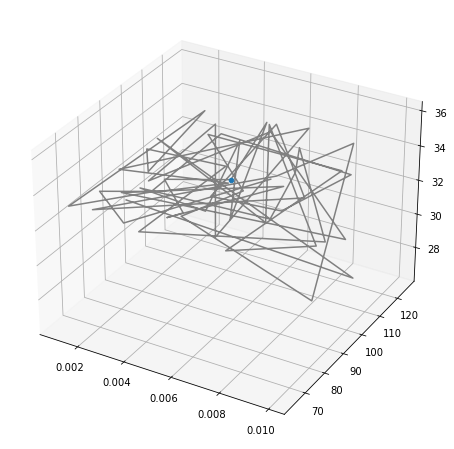

In [69]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_fifth_first
xline = learning_rate_fifth_first
yline = batch_fifth_first

maxlearning = max(rmse_inverse_fifth_first)
xmax = xline[rmse_inverse_fifth_first.index(maxlearning)]
ymax = yline[rmse_inverse_fifth_first.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [70]:
rmse_inverse_fifth_first

[34.640699124137235,
 33.356504527879935,
 33.47641311527926,
 34.09420662199543,
 33.92155906486124,
 32.70590144165588,
 34.835770751961185,
 32.77533662745586,
 33.63439651725643,
 32.76024183801582,
 33.60453220499687,
 28.955763010821144,
 35.03160711399674,
 33.32492178967033,
 33.07793970015148,
 34.31579897192229,
 33.59094940954192,
 35.848892757015506,
 33.919220574793606,
 33.83104314080621,
 33.92673524279183,
 34.65799922126233,
 35.48553737093386,
 34.059711019400225,
 34.636042978551586,
 33.46773087744045,
 28.79057265686902,
 33.02660613407415,
 34.30809991496744,
 33.76623464556277,
 33.97368960912619,
 33.86392480418228,
 33.18447448239593,
 34.99017799855145,
 33.87584230165265,
 34.12786311753993,
 34.65931046255002,
 35.509137086111025,
 34.07032838397139,
 33.99855532769843,
 33.34361361102367,
 30.78264049368161,
 34.252568659915575,
 26.618942595758053,
 34.13384649167357,
 34.16448004838022,
 33.71993879182118,
 33.53107288120564,
 32.08974624306327,
 32.67442

In [71]:
learning_rate_fifth_first

[0.007482920440979424,
 0.0037209931536865584,
 0.0018310473529191804,
 0.00411004654338743,
 0.005849350606030213,
 0.001,
 0.006941241254428767,
 0.0066593058760248645,
 0.00293279116346224,
 0.002453123546691584,
 0.0050248022465167385,
 0.00858408237529774,
 0.003660795834376212,
 0.007318433795078751,
 0.004660153141998068,
 0.0058085818229321184,
 0.003474045415968514,
 0.007061117380134358,
 0.004744608568309848,
 0.0071569383526801185,
 0.0045990790695208065,
 0.006644430349157312,
 0.004373912407604104,
 0.008495436157342778,
 0.008006952516055467,
 0.006487483751614868,
 0.007916990645105294,
 0.004284882338934256,
 0.005391819055095779,
 0.001821367230513913,
 0.0029300592844984626,
 0.0021890297234879986,
 0.001248539092243202,
 0.004507135205135689,
 0.0036832495003537085,
 0.00951209090071441,
 0.00893214019586943,
 0.006829743691998605,
 0.005233493593738921,
 0.00878933317111803,
 0.002243845694808882,
 0.005109463181617874,
 0.00856243204359292,
 0.008281147474858006,


In [72]:
batch_fifth_first

[90.68940830096474,
 64.00731998831007,
 73.39237701229524,
 75.92065352817093,
 89.39311835076288,
 91.16542016814526,
 117.1201221047883,
 73.55562964311869,
 117.10486948954215,
 89.32015437822473,
 120.81260998761655,
 117.12226172810651,
 64.00737417843919,
 99.40488392259589,
 73.50047006612226,
 68.2756740058423,
 85.70872864997332,
 76.22033274718517,
 122.22544759172087,
 74.75689087784812,
 109.88839544414829,
 69.10313191136711,
 64.70339803363655,
 78.04695099655324,
 96.6620755373278,
 118.02250845234147,
 114.65611850970018,
 64.66195094658708,
 93.53231988845232,
 95.64344421172268,
 84.11764676309734,
 120.34166199644937,
 65.48440452263887,
 67.98664847928323,
 111.2744172096985,
 106.61568892497661,
 78.23380214913033,
 69.43704794844545,
 121.29452744300234,
 91.65891933359768,
 65.78572995484397,
 123.26177955379552,
 120.46898114126049,
 103.11669721398432,
 68.00849620454784,
 85.96979474210784,
 110.541926360263,
 112.09524374221081,
 74.15406498679552,
 82.72466

In [111]:
rmse_inverse_fifth_first_max = max(rmse_inverse_fifth_first)
learning_rate_fifth_first_max = learning_rate_fifth_first[rmse_inverse_fifth_first.index(
    rmse_inverse_fifth_first_max)]
batch_fifth_first_max = batch_fifth_first[rmse_inverse_fifth_first.index(rmse_inverse_fifth_first_max)]

learning_rate_fifth_first_test = []
batch_fifth_first_test = []
rmse_inverse_fifth_first_test = []
def objective_function_RMSE_fifth_first_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_fifth_first_test.append(learning_rate)
    batch_fifth_first_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_fifth_first_test.append(1/rmse_lstm)
    return 1/rmse_lstm

optimizer_RMSE_fifth_first_test =BayesianOptimization(f=objective_function_RMSE_fifth_first_test,
    pbounds={'learning_rate': (learning_rate_fifth_first_max-0.001, learning_rate_fifth_first_max+0.001), 
             'batch_size':(batch_fifth_first_max-20, batch_fifth_first_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_fifth_first_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [126]:
print(rmse_inverse_fifth_first)
print(learning_rate_fifth_first)
print(batch_fifth_first)
print(rmse_inverse_fifth_first_test)
print(learning_rate_fifth_first_test)
print(batch_fifth_first_test)

[34.640699124137235, 33.356504527879935, 33.47641311527926, 34.09420662199543, 33.92155906486124, 32.70590144165588, 34.835770751961185, 32.77533662745586, 33.63439651725643, 32.76024183801582, 33.60453220499687, 28.955763010821144, 35.03160711399674, 33.32492178967033, 33.07793970015148, 34.31579897192229, 33.59094940954192, 35.848892757015506, 33.919220574793606, 33.83104314080621, 33.92673524279183, 34.65799922126233, 35.48553737093386, 34.059711019400225, 34.636042978551586, 33.46773087744045, 28.79057265686902, 33.02660613407415, 34.30809991496744, 33.76623464556277, 33.97368960912619, 33.86392480418228, 33.18447448239593, 34.99017799855145, 33.87584230165265, 34.12786311753993, 34.65931046255002, 35.509137086111025, 34.07032838397139, 33.99855532769843, 33.34361361102367, 30.78264049368161, 34.252568659915575, 26.618942595758053, 34.13384649167357, 34.16448004838022, 33.71993879182118, 33.53107288120564, 32.08974624306327, 32.674427095191085, 33.460598623912354, 34.53879562321352

Group 10, learning rate 0.001-0.01, batch size 128-256

In [35]:
learning_rate_fifth_second = []
batch_fifth_second = []
rmse_inverse_fifth_second = []
def objective_function_RMSE_fifth_second(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_fifth_second.append(learning_rate)
    batch_fifth_second.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_fifth_second.append(1/rmse_lstm)
    return 1/rmse_lstm

In [36]:
optimizer_RMSE =BayesianOptimization(f=objective_function_RMSE_fifth_second,
    pbounds={'learning_rate': (0.001, 0.01), 'batch_size':(128, 256)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

0.007482920440979424
181.3788166019295
34.62973317222293


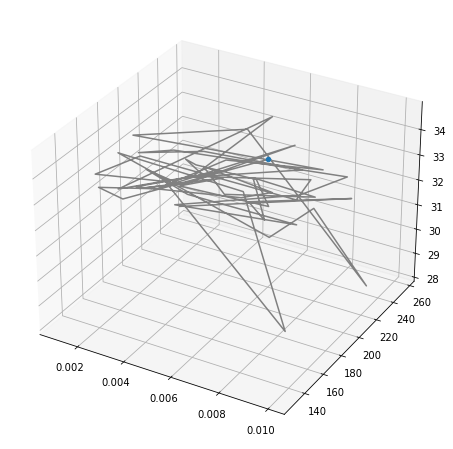

In [73]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = rmse_inverse_fifth_second
xline = learning_rate_fifth_second
yline = batch_fifth_second

maxlearning = max(rmse_inverse_fifth_second)
xmax = xline[rmse_inverse_fifth_second.index(maxlearning)]
ymax = yline[rmse_inverse_fifth_second.index(maxlearning)]
ax.plot3D(xline, yline, zline, 'gray')
ax.scatter(xmax, ymax, maxlearning, 'red')
print(xmax)
print(ymax)
print(maxlearning)

In [74]:
rmse_inverse_fifth_second

[34.62973317222293,
 33.83586214471578,
 33.17927142106428,
 33.55998136864561,
 34.26338228288676,
 34.57063715352721,
 33.3878577753487,
 32.562346542117865,
 28.84298281425157,
 33.99923614745594,
 33.678702125209895,
 33.15049212660333,
 32.764245166467894,
 28.293870472259012,
 34.138874790885,
 33.616581362802734,
 33.411893467304765,
 33.376790332507994,
 34.07237625212743,
 33.048866863279116,
 33.75867500668145,
 33.75495252379554,
 33.84223831798447,
 33.91212144606854,
 34.12658802565075,
 33.23176142436109,
 34.00000163203964,
 32.86021744929533,
 33.19458855531355,
 33.46579641004812,
 33.48242879040959,
 33.495718027775226,
 33.918078106920895,
 33.34758050981338,
 33.59297368926434,
 33.47482895309155,
 33.24313826293095,
 33.603522081352565,
 34.252973941280146,
 34.50154786628734,
 33.12114574132548,
 33.709937280981386,
 33.32642970233044,
 33.676769101426096,
 33.61512810938758,
 33.26815528912851,
 33.320471759231225,
 33.43495643379226,
 34.23270078511619,
 34.3555

In [75]:
learning_rate_fifth_second

[0.007482920440979424,
 0.0037209931536865584,
 0.0018310473529191804,
 0.00411004654338743,
 0.005849350606030213,
 0.00948303235329331,
 0.001,
 0.003656100495409989,
 0.01,
 0.01,
 0.009346675008290197,
 0.001,
 0.006126782030522219,
 0.00845543225890984,
 0.004660153141998068,
 0.0016608411184732847,
 0.002126710261046023,
 0.008632682499793732,
 0.00900344530362921,
 0.004615112615893832,
 0.00404767307422617,
 0.004592387576862021,
 0.007103463513537474,
 0.008495436157342778,
 0.005258308621807817,
 0.006487483751614868,
 0.004722465415982213,
 0.0028304916134046175,
 0.005391819055095779,
 0.004671339660892728,
 0.0029300592844984626,
 0.005189615978347228,
 0.009958612637334462,
 0.005037378968662747,
 0.008760144522861415,
 0.00951209090071441,
 0.0027804468484273277,
 0.002133036255324475,
 0.0048194558959712384,
 0.00878933317111803,
 0.004301981732885123,
 0.005109463181617874,
 0.002666236646678595,
 0.005687656615747028,
 0.003427733766663145,
 0.0067535586383912945,
 0.

In [76]:
batch_fifth_second

[181.3788166019295,
 128.01463997662015,
 146.78475402459048,
 151.84130705634186,
 178.78623670152575,
 186.8435729621753,
 199.04426402356225,
 255.97074095009208,
 225.57036635261457,
 163.60562228179091,
 135.09166268095456,
 184.0297955885405,
 189.76007852881276,
 176.2042061454788,
 147.00094013224452,
 147.71992271281349,
 180.63199150633523,
 181.40121486944676,
 186.84682975769573,
 186.82396758403587,
 181.36171299278578,
 178.80557666070274,
 178.76313715138423,
 156.09390199310647,
 147.02420750646186,
 236.04501690468294,
 147.0463584324466,
 163.58154879573294,
 187.06463977690464,
 163.63112406953957,
 168.23529352619468,
 156.06859094244504,
 146.98016410616293,
 147.06985580182476,
 181.37879694903282,
 213.23137784995322,
 199.0443453887239,
 178.7861048508015,
 181.37931386485894,
 183.31783866719536,
 181.37194887789778,
 246.52355910759104,
 147.00517271306057,
 183.31544096412892,
 147.0239810733193,
 171.93958948421567,
 183.3221176327367,
 186.84482125466255,
 

In [112]:
rmse_inverse_fifth_second_max = max(rmse_inverse_fifth_second)
learning_rate_fifth_second_max = learning_rate_fifth_second[rmse_inverse_fifth_second.index(
    rmse_inverse_fifth_second_max)]
batch_fifth_second_max = batch_fifth_second[rmse_inverse_fifth_second.index(rmse_inverse_fifth_second_max)]

learning_rate_fifth_second_test = []
batch_fifth_second_test = []
rmse_inverse_fifth_second_test = []
def objective_function_RMSE_fifth_second_test(learning_rate, batch_size):
    # Here we need to pre-define an objective function that we want to minmize
    lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
    learning_rate_fifth_second_test.append(learning_rate)
    batch_fifth_second_test.append(batch_size)
    # this step is to access the default hyperparameter setting of the LSTM model 
    del lstm_param_dict['structure'][0]
    # delete the unnecessary 'structure' item from the dictionary. 
    #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
    lstm_param_dict['learning_rate'] = learning_rate
    # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
    # the step is to make the learning_rate variable
    lstm_param_dict['batch_size'] = int(batch_size)
    lstm_param_dict['num_epochs'] = 9
    # although other hyperparameters are not decision variables, it is important to intentionally 
    #tweak other hyperparameters a little bit
    # to accelerate the searching processing of HyperOpt for optimal learning rate. 
    # Otherwise, in my second and third trials, it would be really time-consuming to 
    # generate a sub-optimal learning rate result
    # the details and assumptions of 'batch_size' and 'num_epochs' can be viewed in below Assumption part. 
    lstm_model = LSTM(**lstm_param_dict)
    # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
    lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
    y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
    # use the updated LSTM model to fit and predict the test data 
    rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    rmse_inverse_fifth_second_test.append(1/rmse_lstm)
    return 1/rmse_lstm

optimizer_RMSE_fifth_second_test =BayesianOptimization(f=objective_function_RMSE_fifth_second_test,
    pbounds={'learning_rate': (learning_rate_fifth_second_max-0.001, learning_rate_fifth_second_max+0.001), 
             'batch_size':(batch_fifth_second_max-20, batch_fifth_second_max+20)},
    verbose=0,
    random_state=1)
    
optimizer_RMSE_fifth_second_test.maximize(n_iter=50)

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

/Users/Jenny/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         84992     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [127]:
print(rmse_inverse_fifth_second)
print(learning_rate_fifth_second)
print(batch_fifth_second)
print(rmse_inverse_fifth_second_test)
print(learning_rate_fifth_second_test)
print(batch_fifth_second_test)

[34.62973317222293, 33.83586214471578, 33.17927142106428, 33.55998136864561, 34.26338228288676, 34.57063715352721, 33.3878577753487, 32.562346542117865, 28.84298281425157, 33.99923614745594, 33.678702125209895, 33.15049212660333, 32.764245166467894, 28.293870472259012, 34.138874790885, 33.616581362802734, 33.411893467304765, 33.376790332507994, 34.07237625212743, 33.048866863279116, 33.75867500668145, 33.75495252379554, 33.84223831798447, 33.91212144606854, 34.12658802565075, 33.23176142436109, 34.00000163203964, 32.86021744929533, 33.19458855531355, 33.46579641004812, 33.48242879040959, 33.495718027775226, 33.918078106920895, 33.34758050981338, 33.59297368926434, 33.47482895309155, 33.24313826293095, 33.603522081352565, 34.252973941280146, 34.50154786628734, 33.12114574132548, 33.709937280981386, 33.32642970233044, 33.676769101426096, 33.61512810938758, 33.26815528912851, 33.320471759231225, 33.43495643379226, 34.23270078511619, 34.355573329654966, 33.76560976247545, 33.84195520566738

In [114]:
rmse_inverse_fifth_second_max

34.62973317222293

In [113]:
rmse_inverse_fifth_second_test

[28.861637570438035,
 33.05255776228021,
 34.47273030038154,
 33.40532261987728,
 34.31157098044248,
 31.758307595034584,
 33.73302459672285,
 32.206531896091896,
 28.955048858123273,
 33.95367015523035,
 34.10275828952305,
 28.938861607762657,
 34.205641483714636,
 34.03016856399952,
 33.84276227461079,
 33.72930985092263,
 33.302193627104856,
 33.50571738152931,
 33.75344300657821,
 34.36832613203284,
 32.84893683253114,
 33.43416522263936,
 33.68419835709627,
 33.43373568953801,
 33.71270449607848,
 32.38237249288223,
 33.81907712052924,
 35.02448903970892,
 34.08590209286617,
 33.85897622550564,
 28.75259013712547,
 34.35275476666175,
 34.101406600233446,
 34.21839576981921,
 33.6133310806418,
 34.747226815034615,
 33.60950798607227,
 33.1565506747607,
 33.80341559786402,
 32.41354965797469,
 33.20118844504672,
 33.55413888147868,
 33.02174527228207,
 33.73021968159238,
 34.449166826123374,
 33.6829145032667,
 33.96655818178176,
 33.47095336233434,
 34.202947709466606,
 34.17827816